# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import joblib


#  Loading and Storing Data

In [2]:
base_directory = 'IntTemporalData'

i_range = [i for i in range(20, 54) if i not in {22, 26, 30, 34, 48}]
j_range = range(1, 41)

data = {}

for i in i_range:
    for j in j_range:
        input_file = os.path.join(base_directory, f'Run {i} - BL4, s39708', f'Run_{i}_BL4_s39708_InjPulsePower_InjEnergyFactor_{j}.csv')
        output_file = os.path.join(base_directory, f'Run {i} - BL4, s39708', f'Run_{i}_BL4_s39708_UVDBS_Power_InjEnergyFactor_{j}.csv')

        if os.path.isfile(input_file) and os.path.isfile(output_file):
            input_data = pd.read_csv(input_file, header=None).iloc[0].values
            output_data = pd.read_csv(output_file, header=None).iloc[0].values[59:59+576]
            data[(i, j)] = {'input': input_data, 'output': output_data}
        else:
            print(f"Files not found for i={i}, j={j}: Skipping.")


# Preparing Data for Training

In [3]:
all_input_data = np.array([data[(i, j)]['input'] for i, j in data.keys()])
all_output_data = np.array([data[(i, j)]['output'] for i, j in data.keys()])

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
all_input_data = torch.tensor(input_scaler.fit_transform(all_input_data)).float()
all_output_data = torch.tensor(output_scaler.fit_transform(all_output_data)).float()


# Creating Dataset and Splitting

In [4]:
dataset = TensorDataset(all_input_data, all_output_data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Defining the Neural Network



In [5]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initializing Model, Loss, and Optimizer

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFeedForwardNN(input_dim=576, hidden_dim=128, output_dim=576).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Training and Validation Loop

In [7]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch [1/50], Train Loss: 0.3396, Validation Loss: 0.1959
Epoch [2/50], Train Loss: 0.1190, Validation Loss: 0.0687
Epoch [3/50], Train Loss: 0.0536, Validation Loss: 0.0460
Epoch [4/50], Train Loss: 0.0377, Validation Loss: 0.0311
Epoch [5/50], Train Loss: 0.0247, Validation Loss: 0.0195
Epoch [6/50], Train Loss: 0.0165, Validation Loss: 0.0139
Epoch [7/50], Train Loss: 0.0124, Validation Loss: 0.0116
Epoch [8/50], Train Loss: 0.0103, Validation Loss: 0.0094
Epoch [9/50], Train Loss: 0.0091, Validation Loss: 0.0084
Epoch [10/50], Train Loss: 0.0084, Validation Loss: 0.0081
Epoch [11/50], Train Loss: 0.0081, Validation Loss: 0.0085
Epoch [12/50], Train Loss: 0.0076, Validation Loss: 0.0072
Epoch [13/50], Train Loss: 0.0075, Validation Loss: 0.0071
Epoch [14/50], Train Loss: 0.0070, Validation Loss: 0.0067
Epoch [15/50], Train Loss: 0.0070, Validation Loss: 0.0067
Epoch [16/50], Train Loss: 0.0067, Validation Loss: 0.0064
Epoch [17/50], Train Loss: 0.0062, Validation Loss: 0.0060
Epoch 

# Saving Scalers

In [13]:
scaler_folder = "scalers/denoiser"
os.makedirs(scaler_folder, exist_ok=True)
joblib.dump(input_scaler, os.path.join(scaler_folder, "input_scaler.pkl"))
joblib.dump(output_scaler, os.path.join(scaler_folder, "output_scaler.pkl"))


['scalers/denoiser\\output_scaler.pkl']

# Plotting Loss

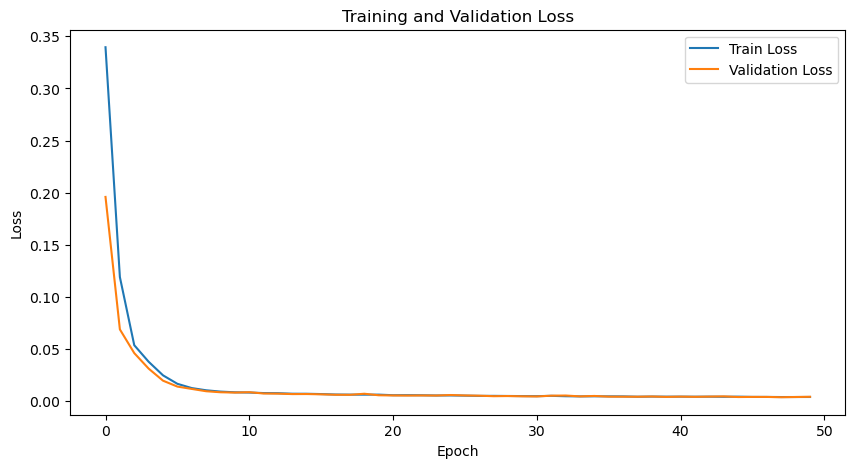

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [11]:
torch.save(model.state_dict(), 'final_models/denoiser.pth')
print("Model saved as final_models/denoiser.pth")


Model saved as final/denoiser.pth


# Testing

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
class SimpleFeedForwardNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFeedForwardNN(input_dim=576, hidden_dim=128, output_dim=576).to(device)
model.load_state_dict(torch.load('final_models/denoiser.pth'))
model.eval()

input_scaler = joblib.load('final_op/denoiser/scalers/denoiser/input_scaler.pkl')
output_scaler = joblib.load('final_op/denoiser/scalers/denoiser/output_scaler.pkl')

In [4]:
time_data = pd.read_csv('TimeAxis.csv', header=None).iloc[0].values
test_runs = [22, 26, 30, 34, 48]
j_range = range(1, 41)

# Initialize a list for results
results = []

# Create folders for saving outputs
output_folder = "final_op/denoiser"
os.makedirs(output_folder, exist_ok=True)
csv_folder = os.path.join(output_folder, "csv")
plots_folder = os.path.join(output_folder, "plots")
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(plots_folder, exist_ok=True)

In [16]:
total_mse = 0
total_energy_difference = 0
total_files = 0
dt = 0.025
total_files = 0

for run in test_runs:
    for j in j_range:
        input_file_path = f'IntTemporalTestData/Run {run} - BL4, s39708/Run_{run}_BL4_s39708_InjPulsePower_InjEnergyFactor_{j}.csv'
        ground_truth_file_path = f'IntTemporalTestData/Run {run} - BL4, s39708/Run_{run}_BL4_s39708_UVDBS_Power_InjEnergyFactor_{j}.csv'

        if os.path.isfile(input_file_path) and os.path.isfile(ground_truth_file_path):
            input_data = pd.read_csv(input_file_path, header=None).iloc[0].values
            input_data_scaled = input_scaler.transform(input_data.reshape(1, -1))
            input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32).unsqueeze(0).to(device)

            ground_truth_data = pd.read_csv(ground_truth_file_path, header=None).iloc[0].values
            ground_truth_data_truncated = ground_truth_data[59:59+576]

            with torch.no_grad():
                prediction_scaled = model(input_tensor).cpu().numpy().squeeze()
                prediction_original_scale = output_scaler.inverse_transform(prediction_scaled.reshape(1, -1)).squeeze()

            predicted_energy = prediction_original_scale.sum() * dt
            ground_truth_energy = ground_truth_data_truncated.sum() * dt
            
            ground_truth_max = ground_truth_data_truncated.max()
            ground_truth_data_normalized = ground_truth_data_truncated / ground_truth_max

            prediction_max = prediction_original_scale.max()
            prediction_normalized = prediction_original_scale / prediction_max

            input_data_max = input_data.max()
            input_data_normalized = input_data / input_data_max

            mse = mean_squared_error(ground_truth_data_truncated, prediction_original_scale)
            energy_difference = abs(predicted_energy - ground_truth_energy)
            
            total_mse += mse
            total_energy_difference += energy_difference
            total_files += 1

            results.append({
                "Run": run,
                "File": j,
                "MSE": mse,
                "Predicted Energy": predicted_energy,
                "Ground Truth Energy": ground_truth_energy,
                "Energy Difference": energy_difference
            })
            
            predicted_output_csv_path = os.path.join(csv_folder, f"Run_{run}_j_{j}_predicted.csv")
            pd.DataFrame(prediction_original_scale).to_csv(predicted_output_csv_path, index=False, header=False)

            # Plot the data
            plt.figure(figsize=(10, 5))
            plt.plot(time_data, input_data_normalized.squeeze(), label='Input Pulse', color='steelblue')
            plt.plot(time_data, prediction_normalized.squeeze(), label='Predicted Output Pulse', color='green')
            plt.plot(time_data, ground_truth_data_normalized, label='Ground Truth Pulse', color='orange')
            plt.title(f'Normalized Input vs Predicted vs Ground Truth (Run {run}, File {j})', fontsize=16, fontweight='bold')
            plt.xlabel('Time(ns)', fontsize=14)
            plt.ylabel('Power Factor', fontsize=15)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            plt.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=1, frameon=True)

            plt.tight_layout()
            #plt.show()

            plot_file_path = os.path.join(plots_folder, f'Run_{run}_j_{j}_comparison.png')
            plt.savefig(plot_file_path, bbox_inches='tight')
            plt.close()


            print(f"Run {run}, File {j} -> MSE: {mse:.4f}, Predicted Energy: {predicted_energy:.4f}, "
                  f"Ground Truth Energy: {ground_truth_energy:.4f}, Energy Difference: {energy_difference:.4f}")
        else:
            print(f"Files not found for Run {run}, File {j}")

Run 22, File 1 -> MSE: 0.4956, Predicted Energy: 3.0955, Ground Truth Energy: 1.0571, Energy Difference: 2.0384
Run 22, File 2 -> MSE: 0.1813, Predicted Energy: 5.2475, Ground Truth Energy: 5.3221, Energy Difference: 0.0746
Run 22, File 3 -> MSE: 0.3638, Predicted Energy: 12.6859, Ground Truth Energy: 13.8979, Energy Difference: 1.2120
Run 22, File 4 -> MSE: 0.2804, Predicted Energy: 30.2384, Ground Truth Energy: 28.0902, Energy Difference: 2.1481
Run 22, File 5 -> MSE: 0.4344, Predicted Energy: 51.0279, Ground Truth Energy: 47.7449, Energy Difference: 3.2831
Run 22, File 6 -> MSE: 0.2387, Predicted Energy: 74.3725, Ground Truth Energy: 73.0204, Energy Difference: 1.3521
Run 22, File 7 -> MSE: 0.3439, Predicted Energy: 106.5238, Ground Truth Energy: 103.5129, Energy Difference: 3.0109
Run 22, File 8 -> MSE: 0.3323, Predicted Energy: 143.1717, Ground Truth Energy: 138.9285, Energy Difference: 4.2432
Run 22, File 9 -> MSE: 0.3386, Predicted Energy: 181.0580, Ground Truth Energy: 178.9014

Run 26, File 31 -> MSE: 0.6005, Predicted Energy: 1762.0266, Ground Truth Energy: 1760.3548, Energy Difference: 1.6717
Run 26, File 32 -> MSE: 0.5203, Predicted Energy: 1840.9537, Ground Truth Energy: 1839.7134, Energy Difference: 1.2403
Run 26, File 33 -> MSE: 0.5250, Predicted Energy: 1922.3137, Ground Truth Energy: 1919.1661, Energy Difference: 3.1476
Run 26, File 34 -> MSE: 0.8083, Predicted Energy: 2002.4629, Ground Truth Energy: 1998.6774, Energy Difference: 3.7855
Run 26, File 35 -> MSE: 0.8473, Predicted Energy: 2079.8928, Ground Truth Energy: 2078.1881, Energy Difference: 1.7047
Run 26, File 36 -> MSE: 0.7315, Predicted Energy: 2161.6316, Ground Truth Energy: 2157.6918, Energy Difference: 3.9398
Run 26, File 37 -> MSE: 0.9674, Predicted Energy: 2242.1371, Ground Truth Energy: 2237.1499, Energy Difference: 4.9872
Run 26, File 38 -> MSE: 1.0648, Predicted Energy: 2321.0041, Ground Truth Energy: 2316.5365, Energy Difference: 4.4676
Run 26, File 39 -> MSE: 1.5426, Predicted Energy

Run 34, File 21 -> MSE: 0.4281, Predicted Energy: 945.4618, Ground Truth Energy: 941.6884, Energy Difference: 3.7734
Run 34, File 22 -> MSE: 0.4778, Predicted Energy: 1017.9308, Ground Truth Energy: 1014.3903, Energy Difference: 3.5405
Run 34, File 23 -> MSE: 0.4727, Predicted Energy: 1091.5598, Ground Truth Energy: 1087.9584, Energy Difference: 3.6014
Run 34, File 24 -> MSE: 0.5922, Predicted Energy: 1166.9189, Ground Truth Energy: 1162.2893, Energy Difference: 4.6296
Run 34, File 25 -> MSE: 0.4518, Predicted Energy: 1240.4011, Ground Truth Energy: 1237.2706, Energy Difference: 3.1304
Run 34, File 26 -> MSE: 0.5155, Predicted Energy: 1315.3359, Ground Truth Energy: 1312.8127, Energy Difference: 2.5233
Run 34, File 27 -> MSE: 0.7424, Predicted Energy: 1393.0596, Ground Truth Energy: 1388.8284, Energy Difference: 4.2312
Run 34, File 28 -> MSE: 0.4933, Predicted Energy: 1467.6254, Ground Truth Energy: 1465.2457, Energy Difference: 2.3797
Run 34, File 29 -> MSE: 0.6245, Predicted Energy: 

In [12]:
average_mse = total_mse / total_files
mean_energy_difference = total_energy_difference / total_files

print(f"\nOverall Metrics")
print(f"Average MSE: {average_mse:.4f}")
print(f"Mean Energy Difference: {mean_energy_difference:.4f}")


Overall Metrics
Average MSE: 0.9476
Mean Energy Difference: 3.6608


In [13]:
results_df = pd.DataFrame(results)
csv_output_path = os.path.join(output_folder, "finaltesting_results_d.csv")
results_df.to_csv(csv_output_path, index=False)
print(f"\nTesting completed. Results saved to '{csv_output_path}'. Plots saved in '{plots_folder}'.")


Testing completed. Results saved to 'final_op/denoiser\finaltesting_results_d.csv'. Plots saved in 'final_op/denoiser\plots'.


In [8]:
print(f"Total files: {total_files}")

Total files: 200


In [18]:
import torch.nn as nn

# Example model
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Instantiate the model
model = SimpleFeedForwardNN(input_dim=576, hidden_dim=128, output_dim=576)

# Count trainable parameters
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_trainable_params(model)}")


Trainable Parameters: 164672
